# 分析
- 基本分析
    - 日付別テキスト出現数・出現率
    - 出現単語
- 極性分析
    - 極性の辞書の準備
    - 極性の割り当て
- LDA
    - LDA準備
    - LDA実行

# 0.Prepare

## import 

In [ ]:
from time import time
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import pickle
import numpy as np
from tqdm import tqdm
import re
from collections import Counter

import plotly.express as px
import datetime
from gensim.corpora import Dictionary

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# preprocess_data
%cd '/content/drive/MyDrive/03_学校/高齢者ドライバー/github/'

/content/drive/MyDrive/03_学校/高齢者ドライバー/github


In [ ]:
path = 'data/'
dfs = []
for name in ['yng', 'mid', 'old']:
    df = pickle.load(open(f'{path}df_{name}.txt', 'rb'))[['text', 'time', 'words']]
    dfs.append(df)
    print(name, df.shape)

yng (85788, 3)
mid (21906, 3)
old (638173, 3)


In [ ]:
path = 'data/'
dfs = []
for name in ['yng', 'mid', 'old']:
    df = pickle.load(open(f'{path}df_{name}.txt', 'rb'))[['text', 'time', 'words']]
    dfs.append(df)
    print(name, df.shape)

yng (85788, 3)
mid (21906, 3)
old (638173, 3)


## 1. 基本分析

### 1.1 日付別テキスト出現数・出現率



In [ ]:
df_base = pd.read_excel('data/base_count.xlsx', index_col=0)
df_base = df_base.set_index('date')

In [ ]:
concat_dfs = [df_base]
for df in dfs:
    
    concat_dfs.append(df['time'].value_counts().sort_index())


In [ ]:
count_df = pd.concat(concat_dfs, axis=1).fillna(0).astype(int)
count_df.columns = ['base', 'yng', 'mid', 'old']
count_df

,base,yng,mid,old
2010-01-01,1538115,0,0,3
2010-01-02,1283801,2,0,5
2010-01-03,1359827,1,0,1
2010-01-04,1448832,6,0,3
2010-01-05,1494433,2,0,4
...,...,...,...,...
2021-12-27,52665977,22,14,120
2021-12-28,52020645,17,10,193
2021-12-29,52156318,28,10,157
2021-12-30,55501973,21,7,174


In [ ]:
freq_df = count_df[['yng', 'mid', 'old']].copy()
for c in freq_df.columns:
    freq_df[c] = freq_df[c] / count_df['base']

In [ ]:
freq_df

,yng,mid,old
2010-01-01,0.000000e+00,0.000000e+00,1.950439e-06
2010-01-02,1.557874e-06,0.000000e+00,3.894685e-06
2010-01-03,7.353877e-07,0.000000e+00,7.353877e-07
2010-01-04,4.141267e-06,0.000000e+00,2.070633e-06
2010-01-05,1.338300e-06,0.000000e+00,2.676600e-06
...,...,...,...
2021-12-27,4.177270e-07,2.658263e-07,2.278511e-06
2021-12-28,3.267933e-07,1.922314e-07,3.710065e-06
2021-12-29,5.368477e-07,1.917313e-07,3.010182e-06
2021-12-30,3.783649e-07,1.261216e-07,3.135024e-06


In [ ]:
# name = 'count_data'
# count_df.to_csv(f'output/analysis/{name}.csv')
# name = 'freq_data'
# count_df.to_csv(f'output/analysis/{name}.csv')

### 1.2 出現単語

In [ ]:
def create_all_dic(df_words):
    all_words= []
    for words in df_words:
        all_words.extend(words)
    all_dic_tupple = Counter(all_words).most_common()
    all_dic = {}
    for x in all_dic_tupple:
        all_dic[x[0]] = x[1]
    return all_dic


In [ ]:
dics = []
names = ['yng', 'mid', 'old']
for df, name in zip(dfs, names):
    dic = create_all_dic(df['words'])
    dics.append(dic)
    print(len(dic))
    df_dic = pd.DataFrame(data=dic.values(), index=dic.keys(), columns=['count'])
    # df_dic.to_csv(f'output/analysis/{name}_dic.csv')

2485
2593
2122


## 2. 極性スコア

### 2.0 import 

In [ ]:
# 翻訳
!pip install deep_translator
from deep_translator import GoogleTranslator
model = GoogleTranslator(source='auto',target='en')
translated = model.translate("Hello")
print(translated)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hello


In [ ]:
# GoogleTranslator.__version__

In [ ]:
# 類語
!pip install chikkarpy

# https://zenn.dev/sorami/articles/3742e761543e08
# https://github.com/WorksApplications/chikkarpy

from chikkarpy import Chikkar
from chikkarpy.dictionarylib import Dictionary

chikkar = Chikkar()

# デフォルトのシステム同義語辞書を使う場合，Dictionaryの引数は省略可能 You may omit the ``Dictionary`` arguments if you want to use the system synonym dictionary
system_dic = Dictionary()
chikkar.add_dictionary(system_dic)
# chikkar.enable_verb()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 原形取得
!mkdir treetagger
%cd treetagger
# Download the tagger package for your system (PC-Linux, Mac OS-X, ARM64, ARMHF, ARM-Android, PPC64le-Linux).
!wget https://cis.lmu.de/~schmid/tools/TreeTagger/data/tree-tagger-linux-3.2.4.tar.gz
!tar -xzvf tree-tagger-linux-3.2.4.tar.gz
# Download the tagging scripts into the same directory.
!wget https://cis.lmu.de/~schmid/tools/TreeTagger/data/tagger-scripts.tar.gz
!gunzip tagger-scripts.tar.gz
# Download the installation script install-tagger.sh.
!wget https://cis.lmu.de/~schmid/tools/TreeTagger/data/install-tagger.sh
# Download the parameter files for the languages you want to process.
# list of all files (parameter files) https://cis.lmu.de/~schmid/tools/TreeTagger/#parfiles
!wget https://cis.lmu.de/~schmid/tools/TreeTagger/data/english.par.gz
!sh install-tagger.sh
%cd ..
!pip install treetaggerwrapper

import treetaggerwrapper as ttw
tagger = ttw.TreeTagger(TAGLANG='en', TAGDIR='treetagger/')

# 処理をする文を指定
line = "He has lots of books, and I have as many books."

# treetaggerによる処理 
tags = tagger.TagText(line)

# 原形のみをリスト("ori_words")に格納
ori_words = []
for tag in tags:
    ori_words.append(tag.split("\t")[2])

# 必要に応じて、abc順に並べ替える
# ("key=str.lower" をつけると、小文字での並べ替え)
# ori_words.sort(key=str.lower)

# 表示してチェックしてみる
print(ori_words)

def get_en_base(word):
    # treetaggerによる処理 
    tag = tagger.TagText(word)[0]
    return tag.split("\t")[2]

mkdir: cannot create directory ‘treetagger’: File exists
/content/drive/MyDrive/03_学校/高齢者ドライバー/github/treetagger
--2023-02-04 07:43:18--  https://cis.lmu.de/~schmid/tools/TreeTagger/data/tree-tagger-linux-3.2.4.tar.gz
Resolving cis.lmu.de (cis.lmu.de)... 129.187.148.72, 2001:4ca0:4f01::5
Connecting to cis.lmu.de (cis.lmu.de)|129.187.148.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1889240 (1.8M) [application/x-gzip]
Saving to: ‘tree-tagger-linux-3.2.4.tar.gz.1’

tree-tagger-linux-3 100%[===================>]   1.80M  1.05MB/s    in 1.7s    

2023-02-04 07:43:22 (1.05 MB/s) - ‘tree-tagger-linux-3.2.4.tar.gz.1’ saved [1889240/1889240]

bin/
bin/train-tree-tagger
bin/separate-punctuation
bin/tree-tagger
bin/tree-tagger-flush
cmd/
cmd/lookup.perl
COPYRIGHT
doc/
doc/sigdat95.pdf
doc/nemlap94.pdf
FILES
README
Release-Notes
--2023-02-04 07:43:22--  https://cis.lmu.de/~schmid/tools/TreeTagger/data/tagger-scripts.tar.gz
Resolving cis.lmu.de (cis.lmu.de)... 129.

In [ ]:
# !pip list

### 2.1 def NRC

In [ ]:
def count_has_pn(df):
    pn = df['pn']
    n_all = len(pn)
    n_null = len([x for x in pn if x is None])
    n_get = n_all - n_null
    print(f'{n_all}単語中{n_null}単語({round(n_null/n_all*100, 1)}%)は欠損値({n_get}の単語が割り当て済み)')

In [ ]:
tagger = ttw.TreeTagger(TAGLANG='en', TAGDIR='treetagger/')
def get_en_base(word):
    # treetaggerによる処理 
    tag = tagger.TagText(word)[0]
    return tag.split("\t")[2]

In [ ]:
# 翻訳
model_en = GoogleTranslator(source='auto',target='en')
def max1(x):
    if x < -1:
        x = -1
    if x > 1:
        x = 1 
    return x

def calc_tmp_score(translated, dic):
    tmp_score = 0    
    tmp_flag = False

    for tr in translated.split():
        if tr in dic.keys():
            tmp_score += dic[tr]
            tmp_flag = True
    
    return max1(tmp_score), tmp_flag

In [ ]:
tagger = ttw.TreeTagger(TAGLANG='en', TAGDIR='treetagger/')
def prepare_nrc():
    nrc_path = 'data/nrc_emotion_lexicon.xlsx'
    pn_df = pd.read_excel(nrc_path)
    pn_df['pn'] = pn_df['Positive'] - pn_df['Negative']
    pn_df = pn_df[['En', 'Ja', 'pn']]
    pn_df['pn'].value_counts()

    # 日本語辞書(もとから原形)
    pn_dict_ja = {}
    for k, v in zip(pn_df['Ja'], pn_df['pn']):
        pn_dict_ja[k] = v

    # 英語辞書
    pn_dict_en = {}
    for k, v in zip(pn_df['En'], pn_df['pn']):
        pn_dict_en[k] = v
    
    # 英語原形辞書
    pn_dict_en_base = {}
    li = []
    for k,v in tqdm(pn_dict_en.items()):
        try:
            k = get_en_base(k)
        except Exception:
            k = k
        pn_dict_en_base[k] = v
        li.append(k)
    
    pn_df['En_base'] = li

    nrc_df = pn_df.reindex(columns=['En', 'Ja', 'En_base', 'pn'])

    return pn_dict_ja, pn_dict_en, pn_dict_en_base, nrc_df

### 2.2 NRC

In [ ]:
nrc_ja, nrc_en, nrc_en_base, nrc_df = prepare_nrc()

/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
100%|██████████| 14182/14182 [00:06<00:00, 2236.06it/s]


In [ ]:
len(nrc_ja), len(nrc_en), len(nrc_en_base), len(nrc_df)

(11792, 14182, 13138, 14182)

### 2.3 def main

In [ ]:
def create_all_dic_ratio(all_dic, n):
    for (k,v) in all_dic.items():
        all_dic[k] = round(all_dic[k] / n, 4)
    return all_dic

def reduce_df_words(df, all_dic_ratio, use_ratio=0.001):
    use_words = []
    for (k,v) in all_dic_ratio.items():
        if v >= use_ratio:
            use_words.append(k)
        else:
            break

    print(f'出現率{use_ratio}以上の単語数: {len(use_words)}')
    
    for i, words in tqdm(enumerate(df['words'])):
        reduced_words = []
        for w in words:
            if w in use_words:
                reduced_words.append(w)
            else:
                continue
        df.at[i, 'words'] = reduced_words

    return df    

In [ ]:
def create_df_pn_pre(df, topic):
    all_dic = create_all_dic(df['words'])
    if topic == 0:
        all_dic_ratio = create_all_dic_ratio(all_dic, len(df))
        df = reduce_df_words(df, all_dic_ratio)
        df_words = [k for k,v in all_dic.items() if v >= 0.001]
    else:
        df_words = [k for k,v in all_dic.items()]

    df_pn = pd.DataFrame(index=df_words)
    df_pn['pn'] = None
    display(df_pn.head(3))
    count_has_pn(df_pn)
    return df_pn

In [ ]:
def create_pn_dict(df):
    tagger = ttw.TreeTagger(TAGLANG='en', TAGDIR='treetagger/')

    # 日本語適用
    for w in df.index:
        if w in nrc_ja.keys():
            df.at[w, 'pn'] = nrc_ja[w]
            # print(w)
    count_has_pn(df)

    # 英語適用
    df['En'] = None
    for w, pn in tqdm(zip(df.index, df['pn'])):
        if pn is None:
            try:
                translated = model_en.translate(w).lower()
                df.at[w, 'En'] = translated

                tmp_score, tmp_flag = calc_tmp_score(translated, nrc_en)
                if tmp_flag:
                    df.at[w, 'pn'] = tmp_score
                    # print(w,translated)
                else:
                    continue
            except Exception:
                continue
    count_has_pn(df)

    #英語原形辞書適用
    for w, en, pn in zip(df.index, df['En'], df['pn']):
        if pn is None:
            if en in nrc_en_base.keys():
                df.at[w, 'pn'] = nrc_en_base[en]
                # print(w,en)
    count_has_pn(df)
    
    # df_pnの英語を原形にする
    for w, en, pn in zip(df.index, df['En'], df['pn']):
        if pn is None:
            try:
                en_ = get_en_base(en)
                if en_ in nrc_en_base.keys():
                    df.at[w, 'pn'] = nrc_en_base[en_]
                    print(f'{w} -> {en} -> {en_}')
            except Exception:
                continue            
    count_has_pn(df)

    # 類語適用
    chikkar = Chikkar()
    system_dic = Dictionary()
    chikkar.add_dictionary(system_dic)
    chikkar.enable_verb()

    for w, pn in tqdm(zip(df.index, df['pn'])):
        if pn is None:
            try:
                synonym_list = chikkar.find(w)
                # df_pn.at[w, '類語'] = synonym_list
                for s in synonym_list:
                    if s in nrc_ja.keys():
                        df.at[w, 'pn'] = nrc_ja[s]
                        print(f'{w} is scored by {s}')
                        break
            except Exception:
                continue
    count_has_pn(df)
    
    ### 手順fの単語チェック用
    others = []
    for w, pn in tqdm(zip(df.index, df['pn'])):
        if pn is None:
            others.append(w)
    print(others)
    ### 手順fの単語チェック用

    # 整形    
    df = df.fillna(0)
    count_has_pn(df)
    pn_dict = {}
    for k,v in zip(df.index, df['pn']):
        pn_dict[k] = v

    return pn_dict


In [ ]:
def calc_pn_score(df, dic):
    pn_score = []
    for words in df['words']:
        score = 0
        n_words = len(words)
        for w in words:
            if w in dic.keys():
                score += dic[w]
        score /= n_words
        pn_score.append(score)
    df['score'] = pn_score
    return df   

def calc_pn_score2(df, dic):
    pn_score = []
    for words in df['words']:
        score = 0
        n_words = len(words)
        for w in words:
            if w not in ['衝突', '暴走', '飲酒']:
                if w in dic.keys():
                    score += dic[w]
        score /= n_words
        pn_score.append(score)
    df['score'] = pn_score
    return df   

### 2.4 main

In [ ]:
%%time
pn_dics = []
pn_dfs = []

for df in dfs:
    topic = 1
    df_pn_pre = create_df_pn_pre(df, topic)
    tagger = ttw.TreeTagger(TAGLANG='en', TAGDIR='treetagger/')
    pn_dict = create_pn_dict(df_pn_pre)
    pn_df = calc_pn_score(df, pn_dict)
    pn_dics.append(pn_dict)
    pn_dfs.append(pn_df)

,pn
言う,None
事故,None
免許,None


2485単語中2485単語(100.0%)は欠損値(0の単語が割り当て済み)
2485単語中1755単語(70.6%)は欠損値(730の単語が割り当て済み)


2485it [02:55, 14.18it/s]


2485単語中645単語(26.0%)は欠損値(1840の単語が割り当て済み)
2485単語中605単語(24.3%)は欠損値(1880の単語が割り当て済み)
怖い -> scared -> scare
かける -> times -> time
入る -> come in -> come
轢く -> run over -> run
対策 -> measures -> measure
男女 -> men and women -> man
教習 -> lessons -> lesson
死傷 -> casualties -> casualty
小学生 -> pupils -> pupil
逃げる -> run away -> run
営業 -> sales -> sale
付く -> attached -> attach
だす -> give out -> give
女子 -> girls -> girl
設定 -> setting -> set
歩行 -> walking -> walk
連中 -> guys -> guy
皆様 -> ladies and gentlemen -> lady
実家 -> parents' home -> parent
灯火 -> lights -> light
返上 -> give up -> give
帰り道 -> way home -> way
経つ -> passes -> pass
罰則 -> penalties -> penalty
諦める -> give up -> give
ども -> guys -> guy
歩き -> walking -> walk
デート -> dating -> date
かなう -> come true -> come
考え方 -> way to think -> way
ひき殺す -> run over -> run
育つ -> growing up -> grow
やってくる -> come up -> come
言い方 -> way of saying -> way
マシ -> better -> good
薬物 -> drugs -> drug
作り -> making -> make
ご時世 -> times -> time
乗り回す -> drive around -> drive


2485it [00:00, 76898.67it/s]


多い is scored by 多数
違う is scored by 違い
取り上げる is scored by 没収
通常 is scored by 一般
全て is scored by オール
すべて is scored by オール
自己 is scored by 自分
比べる is scored by 比較
全部 is scored by オール
自身 is scored by 自分
成人 is scored by アダルト
関わる is scored by 関与
社員 is scored by 労働者
使用 is scored by 利用
着る is scored by 着用
発進 is scored by 開始
トラブル is scored by 問題
出かける is scored by 外出
旦那 is scored by 亭主
現れる is scored by 出現
向上 is scored by 進歩
メール is scored by 電子メール
罰金 is scored by ペナルティ
パワー is scored by 力
家庭 is scored by 家
近頃 is scored by 最近
事例 is scored by ケース
異なる is scored by 違い
アプリ is scored by アプリケーション
色々 is scored by いろいろ
ナビ is scored by ナビゲーション
出掛ける is scored by 外出
インターネット is scored by ネット
出歩く is scored by 外出
2485単語中519単語(20.9%)は欠損値(1966の単語が割り当て済み)


2485it [00:00, 1262457.05it/s]

['言う', '見る', '乗る', '行く', '持つ', '無い', '以上', '取る', '日本人', '出来る', '本当', '少ない', '普通', '10', '自動運転', 'とる', '20代', 'みんな', '奪う', '東京', '駐車', '見える', 'スマホ', '絶対', 'せい', '更新', '確か', '早い', 'かかる', '無理', 'yahoo', '後ろ', '限定', '大丈夫', '起きる', 'アクセル', '家族', 'すごい', '生きる', '降りる', '20', '維持', '18', 'がる', '周り', '30', '厳しい', '言える', '下手', 'おかしい', '上がる', '大変', 'プリウス', '困る', '見かける', '住む', '巻き込む', '慣れる', 'お前', '一緒', '多く', '朝日新聞', '強い', '100', '凄い', '以前', '池袋', 'デジタル', '全員', 'ただ', '10代', '向かう', '20歳', 'トヨタ', '自体', '元気', 'ポケモン', '以下', 'お願い', 'っぽい', '12', '思える', 'nhk', '大阪', '他人', '集まる', '人手', '19', '取れる', 'ボケ', '原付', '所有', 'アメリカ', '普段', 'キレ', '悲しい', '16', 'おじいちゃん', '11', '50', '今時', '統計', '本人', '最後', 'ジジババ', '行ける', '無茶', '一つ', '40', '15', '少子', '24', '通る', '有る', '80', '自覚', '捕まる', '京都', '辛い', '渋谷', '観光', '21', '問う', 'させる', '彼ら', 'ツイート', 'あたり', '頼む', '皆さん', 'ホン', 'くん', '新しい', '帰宅', '持てる', 'なさる', '介護', '使える', '停車', '25', '重い', '反応', 'イキ', '13', '福岡', '彼女', 'あなた', 'amp', '正しい', 'もらえる', '産経新聞', '下がる', '50代', '毎日新聞', '

,pn
男性,None
来る,None
見る,None


2593単語中2593単語(100.0%)は欠損値(0の単語が割り当て済み)
2593単語中1863単語(71.8%)は欠損値(730の単語が割り当て済み)


2593it [02:50, 15.20it/s]


2593単語中719単語(27.7%)は欠損値(1874の単語が割り当て済み)
2593単語中669単語(25.8%)は欠損値(1924の単語が割り当て済み)
怖い -> scared -> scare
かける -> times -> time
入る -> come in -> come
男女 -> men and women -> man
轢く -> run over -> run
逃げる -> run away -> run
女子 -> girls -> girl
小学生 -> pupils -> pupil
営業 -> sales -> sale
付く -> attached -> attach
だす -> give out -> give
対策 -> measures -> measure
歩行 -> walking -> walk
連中 -> guys -> guy
帰り道 -> way home -> way
走り去る -> run away -> run
教習 -> lessons -> lesson
実家 -> parents' home -> parent
灯火 -> lights -> light
皆様 -> ladies and gentlemen -> lady
当局 -> authorities -> authority
ポイ捨て -> littering -> litter
諦める -> give up -> give
わし -> eagle, i -> eagle
設定 -> setting -> set
ども -> guys -> guy
やってくる -> come up -> come
歩き -> walking -> walk
メートル -> meters -> meter
両親 -> parents -> parent
付け -> attached -> attach
経つ -> passes -> pass
かなう -> come true -> come
イラッ -> annoyed -> annoy
出くわす -> come across -> come
坊主 -> shaved -> shave
育つ -> growing up -> grow
罰則 -> penalties -> penalty
駆け寄る -> run

2593it [00:00, 110839.88it/s]


多い is scored by 多数
違う is scored by 違い
通常 is scored by 一般
自己 is scored by 自分
着る is scored by 着用
全て is scored by オール
旦那 is scored by 亭主
自身 is scored by 自分
全部 is scored by オール
発進 is scored by 開始
現れる is scored by 出現
関わる is scored by 関与
社員 is scored by 労働者
取り上げる is scored by 没収
使用 is scored by 利用
トラブル is scored by 問題
ステッカー is scored by シール
比べる is scored by 比較
リストラ is scored by 解雇
すべて is scored by オール
家庭 is scored by 家
メール is scored by 電子メール
ナビ is scored by ナビゲーション
出かける is scored by 外出
パワー is scored by 力
背後 is scored by 後方
成人 is scored by アダルト
あんま is scored by マッサージ
ミニ is scored by コンパクト
2593単語中588単語(22.7%)は欠損値(2005の単語が割り当て済み)


2593it [00:00, 1040848.91it/s]

['見る', '言う', '乗る', '行く', '以上', '本当', '無い', '駐車', '持つ', '後ろ', '普通', '見える', '降りる', '出来る', '10', '見かける', 'プリウス', '取る', '周り', '下手', 'とる', 'みんな', '絶対', '大丈夫', '停車', 'すごい', '無理', '向かう', '確か', '以降', 'スマホ', '早い', '家族', '東京', 'キレ', '30', '更新', '40', 'がる', 'っぽい', '少ない', '一緒', 'せい', 'お前', '20', '40代', 'おかしい', 'お願い', 'かかる', '新しい', '通る', '強い', '以前', '起きる', '帰宅', '21', '自覚', '50代', '言える', '慣れる', '困る', 'ウインカー', '大阪', '凄い', '全員', '生きる', '50', 'アクセル', 'stinger', '捕まる', '大変', '12', '最後', '住む', '普段', '20代', '上がる', '巻き込む', 'イキ', '乗り込む', 'ただ', 'dqn', '自動運転', '以下', 'あなた', 'あたり', 'go', '皆さん', 'yahoo', 'ころ', '日本人', '付近', '11', 'わたし', '100', 'ウィンカー', 'ベンツ', 'nhk', '15', '厳しい', '多く', 'アレ', '無し', 'かけ離れる', '他人', 'amp', '左右', '絡む', '恥ずかしい', '思える', 'ポケモン', '問う', '18', '送迎', '元気', '介護', '昼間', '観光', '名古屋', '無茶', 'チン', '悲しい', '17', '有る', 'ブログ', 'ボケ', 'くん', '頼む', '31', '反応', '自宅', '強引', '取れる', '大好き', 'さま', '一つ', 'ぽい', 'デジタル', '原付', '朝日新聞', '辛い', '横浜', '行ける', 'ツイート', '非常', 'ついてる', 'cm', '辺り', '彼ら', 'タイミング', 'bmw', '不思議'

,pn
事故,None
免許,None
言う,None


2122単語中2122単語(100.0%)は欠損値(0の単語が割り当て済み)
2122単語中1495単語(70.5%)は欠損値(627の単語が割り当て済み)


2122it [02:09, 16.34it/s]


2122単語中569単語(26.8%)は欠損値(1553の単語が割り当て済み)
2122単語中530単語(25.0%)は欠損値(1592の単語が割り当て済み)
怖い -> scared -> scare
対策 -> measures -> measure
かける -> times -> time
轢く -> run over -> run
入る -> come in -> come
返上 -> give up -> give
歩行 -> walking -> walk
死傷 -> casualties -> casualty
付く -> attached -> attach
小学生 -> pupils -> pupil
教習 -> lessons -> lesson
実家 -> parents' home -> parent
逃げる -> run away -> run
両親 -> parents -> parent
だす -> give out -> give
男女 -> men and women -> man
身内 -> relatives -> relative
付け -> attached -> attach
諦める -> give up -> give
営業 -> sales -> sale
罰則 -> penalties -> penalty
設定 -> setting -> set
マシ -> better -> good
皆様 -> ladies and gentlemen -> lady
経つ -> passes -> pass
メートル -> meters -> meter
灯火 -> lights -> light
言い方 -> way of saying -> way
ひかれる -> run over -> run
日間 -> days -> day
都合 -> circumstances -> circumstance
作り -> making -> make
かなう -> come true -> come
連中 -> guys -> guy
づくり -> making -> make
ひき殺す -> run over -> run
叩き -> hitting -> hit
女子 -> girls -> girl
ども -> guys 

2122it [00:00, 82827.51it/s]


多い is scored by 多数
取り上げる is scored by 没収
違う is scored by 違い
全て is scored by オール
発進 is scored by 開始
自身 is scored by 自分
自己 is scored by 自分
関わる is scored by 関与
全部 is scored by オール
すべて is scored by オール
比べる is scored by 比較
旦那 is scored by 亭主
交付 is scored by 供給
通常 is scored by 一般
使用 is scored by 利用
向上 is scored by 進歩
出かける is scored by 外出
事例 is scored by ケース
ステッカー is scored by シール
判定 is scored by 審査
トラブル is scored by 問題
家庭 is scored by 家
罰金 is scored by ペナルティ
色々 is scored by いろいろ
メール is scored by 電子メール
現れる is scored by 出現
ナビ is scored by ナビゲーション
2122単語中456単語(21.5%)は欠損値(1666の単語が割り当て済み)


2122it [00:00, 1122076.79it/s]

['言う', '見る', '行く', '乗る', '以上', '更新', '無い', '出来る', 'アクセル', '本当', '池袋', '家族', '自動運転', 'プリウス', '持つ', '駐車', '10', '大丈夫', '起きる', 'yahoo', '普通', '早い', '東京', 'ボケ', '見える', '少ない', '無理', '絶対', '取る', '限定', '周り', 'nhk', '後ろ', '厳しい', '飯塚', '巻き込む', '介護', '確か', '本人', 'とる', '住む', 'みんな', '奪う', 'せい', '言える', 'おかしい', '30', '大変', '困る', '20', '生きる', 'させる', 'かかる', '朝日新聞', '自覚', '12', '87', '見かける', '11', 'デジタル', 'すごい', 'おじいちゃん', 'お願い', '送迎', '80代', '付き', 'ホーム', '全員', '100', '以前', '大阪', '標識', '行ける', '下手', '思える', '毎日新聞', '15', '降りる', '強い', '20代', '自体', '悲しい', '福岡', '70', '幸三', '一緒', '80', '専用', '他人', '70代', '18', '多く', '上がる', '有る', '少子', 'がる', '反応', '元気', '普段', '通る', 'ウインカー', '決める', '50', '皆さん', '停車', '凄い', 'トヨタ', '過信', '慣れる', '19', 'スマホ', '愛知', '新しい', '40', '頼む', '以下', '過疎', '辛い', '左右', 'お前', 'オンライン', '県内', '無料', '問う', 'あなた', '使える', '向かう', '控える', '60', '搭載', '取れる', 'ただ', '読売新聞', '最後', '横浜', '16', '北海道', 'ほんま', '13', '2019', '一つ', '無し', '維持', '願う', '云々', '扱い', '都内', 'ツイート', '防げる', '昨今', '正しい', '重い', '産経新聞', '実現

CPU times: user 1min 27s, sys: 5.9 s, total: 1min 33s
Wall time: 8min 1s


### 2.5 基礎統計量と分布

In [ ]:
for df in pn_dfs:
    df['year'] = df['time'].map(lambda x: x[:4])
    df = df[['year', 'score']]
    years = df['year'].unique()
    # des = []
    des_mean = []
    des_medium = []

    # 各年にする
    for y in years:
        de = df[df['year']==y]['score'].describe()
        de_mean = de[['mean', 'std']]
        de_medi = de[['25%', '50%', '75%']]
        des_mean.append(de_mean)
        des_medium.append(de_medi)


    # 基礎統計量
    df_mean = pd.concat(des_mean, axis=1)
    df_mean.columns = years
    display(df_mean)
    print()
    df_medium = pd.concat(des_medium, axis=1)
    df_medium.columns = years
    display(df_medium)
    print()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
mean,0.019140,0.025019,-0.002029,0.028476,0.030573,0.046393,-0.017105,-0.002223,-0.000343,-0.034804,0.006692,0.011343
std,0.214855,0.205044,0.202897,0.212826,0.202327,0.199088,0.197595,0.204681,0.200268,0.189772,0.192071,0.193133


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
25%,-0.100000,-0.096429,-0.125,-0.100000,-0.090909,-0.071429,-0.142857,-0.125,-0.125,-0.153846,-0.111111,-0.111111
50%,0.000000,0.000000,0.000,0.000000,0.000000,0.066667,0.000000,0.000,0.000,0.000000,0.000000,0.000000
75%,0.166667,0.142857,0.125,0.166667,0.166667,0.181818,0.111111,0.125,0.125,0.083333,0.125000,0.133333


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
mean,0.079623,0.055648,0.036734,0.058708,0.033680,0.050649,0.025855,0.035407,0.030425,0.000321,0.028054,0.024137
std,0.206828,0.199888,0.219798,0.215690,0.197054,0.219347,0.212311,0.198840,0.196035,0.197860,0.201438,0.198245


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
25%,0.000000,-0.062500,-0.076923,-0.050000,-0.083333,-0.071429,-0.089015,-0.078526,-0.083333,-0.117647,-0.090909,-0.10
50%,0.064583,0.000000,0.000000,0.046537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
75%,0.196875,0.166667,0.166667,0.200000,0.153846,0.187500,0.142857,0.166667,0.153846,0.117647,0.153846,0.15


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
mean,0.008118,-0.020178,-0.036066,-0.014391,-0.031455,-0.049197,-0.065039,-0.049964,-0.044283,-0.063564,-0.041758,-0.046598
std,0.188776,0.206186,0.213763,0.212312,0.209513,0.210339,0.206435,0.210097,0.205605,0.202439,0.200972,0.199605


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
25%,-0.100,-0.142857,-0.166667,-0.142857,-0.157895,-0.166667,-0.181818,-0.166667,-0.166667,-0.181818,-0.166667,-0.166667
50%,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.052632,0.000000,0.000000,-0.052632,0.000000,0.000000
75%,0.125,0.100000,0.090909,0.117647,0.100000,0.076923,0.052632,0.071429,0.076923,0.055556,0.076923,0.076923


In [ ]:
display(pd.concat(des_mean, axis=1))
display(pd.concat(des_medium, axis=1))

,score,score,score,score,score,score,score,score,score,score,score,score
mean,0.008118,-0.020178,-0.036066,-0.014391,-0.031455,-0.049197,-0.065039,-0.049964,-0.044283,-0.063564,-0.041758,-0.046598
std,0.188776,0.206186,0.213763,0.212312,0.209513,0.210339,0.206435,0.210097,0.205605,0.202439,0.200972,0.199605


,score,score,score,score,score,score,score,score,score,score,score,score
25%,-0.100,-0.142857,-0.166667,-0.142857,-0.157895,-0.166667,-0.181818,-0.166667,-0.166667,-0.181818,-0.166667,-0.166667
50%,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.052632,0.000000,0.000000,-0.052632,0.000000,0.000000
75%,0.125,0.100000,0.090909,0.117647,0.100000,0.076923,0.052632,0.071429,0.076923,0.055556,0.076923,0.076923


In [ ]:
pn_dist_count = pd.concat([round(df['score'], 1).value_counts() / len(df) * 100 for df in pn_dfs], axis=1).fillna(0)
pn_dist_count.columns = ['yng', 'mid', 'old']
pn_dist_count 

,yng,mid,old
-1.0,0.053621,0.200858,0.178008
-0.9,0.001166,0.000000,0.001567
-0.8,0.067609,0.041085,0.160145
-0.7,0.228470,0.200858,0.519295
-0.6,0.224973,0.132384,0.414621
-0.5,1.205297,0.926687,2.157565
-0.4,1.952488,1.218844,2.834655
-0.3,4.733762,3.318725,6.709936
-0.2,12.336224,10.257464,15.803708
-0.1,16.374085,14.863508,18.508147


In [ ]:
pn_dist_freq = pd.concat([round(df['score'], 1).value_counts() / len(df) * 100 for df in pn_dfs], axis=1).fillna(0)
pn_dist_freq.columns = ['yng', 'mid', 'old']
pn_dist_freq

,yng,mid,old
-1.0,0.053621,0.200858,0.178008
-0.9,0.001166,0.000000,0.001567
-0.8,0.067609,0.041085,0.160145
-0.7,0.228470,0.200858,0.519295
-0.6,0.224973,0.132384,0.414621
-0.5,1.205297,0.926687,2.157565
-0.4,1.952488,1.218844,2.834655
-0.3,4.733762,3.318725,6.709936
-0.2,12.336224,10.257464,15.803708
-0.1,16.374085,14.863508,18.508147


In [ ]:
# name = 'count_pn_dist'
# count_df.to_csv(f'output/analysis/{name}.csv')
# name = 'freq_pn_dist'
# count_df.to_csv(f'output/analysis/{name}.csv')

## 3. LDA

In [ ]:
# old df
df = dfs[2].copy()

In [ ]:
print(len(df))

638173


In [ ]:
from collections import Counter
from gensim.corpora import Dictionary

def create_bow(bow):
    all_words= []
    for li in tqdm(bow):
        all_words.extend(li)
    print()
    print('all words:', len(all_words))
    word_dict = Counter(all_words).most_common()
    
    return word_dict

def show_word_freq(word_dict, n_use=0):
    all_words = [x[0] for x in word_dict if x[1]>(n_use-1)]
    all_freqs = [x[1] for x in word_dict if x[1]>(n_use-1)]
    print('unique_words:', len(all_words))
    display(pd.DataFrame(round(pd.Series(all_freqs).describe(), 2) ))
    return all_words

def reduce_words(bow, use_words):
    new_bow = []
    for li in tqdm(bow):
        new_li = [w for w in li if w in use_words]
        new_bow.append(new_li)

    return new_bow

def create_corpus(bow):
    # 辞書の作成
    dictionary = Dictionary(bow)
    dic = [i for i in Dictionary(bow).items()]
    print(f'辞書の単語数: {len(dic)}')

    # データに辞書を適用
    corpus = [dictionary.doc2bow(t) for t in bow]
    print(f'データ数: {len(corpus)}')
    print()
    return dictionary, dic, corpus


def prepare_topic_model(df):
    word_dict = create_bow(df['words'])
    for i in word_dict[:5]:
        print(i)
    use_words = show_word_freq(word_dict, n_use=0)
    bow = reduce_words(df['words'], use_words)
    word_dict = create_bow(bow)
    dictionary, dic, corpus = create_corpus(bow)
    return bow, corpus, dictionary

In [ ]:
from gensim.models.ldamodel import LdaModel, CoherenceModel
import matplotlib as plt

def plot_scores(coherence, perplexity, x):
    fig, ax1 = plt.subplots(figsize=(12,5))

    # coherence
    c1 = 'darkturquoise'
    ax1.plot(x, coherence, 'o-', color=c1)
    ax1.set_xlabel('Num Topics')
    ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

    # perplexity
    c2 = 'slategray'
    ax2 = ax1.twinx()
    ax2.plot(x, perplexity, 'o-', color=c2)
    ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

    # Vis
    ax1.set_xticks(x)
    fig.tight_layout()
    plt.show()

def modeling(bow, corpus, dictionary, df, n_topics, plotdata=False, iter=5, ee=100, ue=100,
              applytopic=False):

    def ldamodel(n_topics):
        return LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=n_topics,
                        iterations=iter,
                        eval_every=ee,
                        update_every=1,
                        passes=10,
                        random_state=0)
        
    def count_data(n, cl_ids):
        count = Counter(cl_ids).most_common()
        print(f'n={n}: {[x for x in count]}')
        return count

    def create_dic(count):
        # key(before) -> value(after)
        dic_topic = {}
        for i, x in enumerate(count):
            dic_topic[x[0]] = i
        return dic_topic
    
    def apply_topic(df, n_topics, dic_topic):
        df[f'topic_{n_topics}'] = [dic_topic[k] for k in cl_ids]
        return df

    def get_topic(c):
        mo = model[c]
        cl_id = [m[0] for m in mo]
        cl_va = [m[1] for m in mo]
        return cl_id[np.argmax(cl_va)]

    def TIME(t):
        return round(time()-t, 2)
 
    def plot_data(n_topics):
        for i in range(n_topics):
            x = model.show_topic(i, topn=100)
            te = ','.join([ f'{y[0]}_{str(round(y[1]*100, 2))}' for y in x])
            print(f'topic_{i}: {te}')

    if type(n_topics) == range:
        coherence = []
        perplexity = []

        for n in tqdm(n_topics):
            model = ldamodel(n_topics=n)

            # score
            per = np.exp(-model.log_perplexity(corpus))
            coh = CoherenceModel(model=model, texts=bow, dictionary=dictionary, coherence='c_v').get_coherence()
            coherence.append(coh)
            perplexity.append(per)
            print()
            print(f'topic_{n}')
            print('coherence', coherence)
            print('perplexity', perplexity)

            if plotdata:
                cl_ids = list(map(get_topic, corpus))
                count = count_data(n, cl_ids)
                plot_data(n)
                del model, cl_ids

            print()

        plot_scores(coherence, perplexity, n_topics)

    else:
        t = time()
        model = ldamodel(n_topics=n_topics)
        cl_ids = list(map(get_topic, corpus))
        count = count_data(n_topics, cl_ids)

        if plotdata:
            plot_data(n_topics)
        
        if applytopic:
            dic_topic = create_dic(count)   
            df = apply_topic(df, n_topics, dic_topic)

        print('time:', TIME(t))
        return model

In [ ]:
bow, corpus, dictionary = prepare_topic_model(df)

100%|██████████| 638173/638173 [00:00<00:00, 1187664.42it/s]



all words: 6746870
('事故', 178995)
('免許', 134786)
('言う', 82875)
('良い', 76801)
('来る', 67750)
unique_words: 2122


,0
count,2122.00
mean,3179.49
std,7379.33
min,558.00
25%,899.25
50%,1401.00
75%,2822.25
max,178995.00


100%|██████████| 638173/638173 [00:00<00:00, 1482117.89it/s]



all words: 6746870
辞書の単語数: 2122
データ数: 638173



  7%|▋         | 1/15 [08:09<1:54:06, 489.03s/it]


topic_1
coherence [0.10799132739378467]
perplexity [990.4195522120673]



 13%|█▎        | 2/15 [18:22<2:01:47, 562.14s/it]


topic_2
coherence [0.10799132739378467, 0.28076129037606823]
perplexity [990.4195522120673, 940.7882427399211]



 20%|██        | 3/15 [28:48<1:58:14, 591.22s/it]


topic_3
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202]



 27%|██▋       | 4/15 [39:08<1:50:29, 602.72s/it]


topic_4
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071]



 33%|███▎      | 5/15 [49:29<1:41:33, 609.40s/it]


topic_5
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829]



 40%|████      | 6/15 [59:55<1:32:14, 614.90s/it]


topic_6
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741, 0.48805868067268626]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829, 979.8904624175743]



 47%|████▋     | 7/15 [1:10:39<1:23:14, 624.36s/it]


topic_7
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741, 0.48805868067268626, 0.44430197428164825]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829, 979.8904624175743, 1031.040738986625]



 53%|█████▎    | 8/15 [1:21:11<1:13:08, 626.99s/it]


topic_8
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741, 0.48805868067268626, 0.44430197428164825, 0.49359160732640717]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829, 979.8904624175743, 1031.040738986625, 1047.7520182339535]



 60%|██████    | 9/15 [1:32:05<1:03:31, 635.21s/it]


topic_9
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741, 0.48805868067268626, 0.44430197428164825, 0.49359160732640717, 0.48139720389404583]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829, 979.8904624175743, 1031.040738986625, 1047.7520182339535, 1085.3738192626874]



 67%|██████▋   | 10/15 [1:43:10<53:42, 644.53s/it] 


topic_10
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741, 0.48805868067268626, 0.44430197428164825, 0.49359160732640717, 0.48139720389404583, 0.4396164341202223]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829, 979.8904624175743, 1031.040738986625, 1047.7520182339535, 1085.3738192626874, 1133.7362030575557]



 73%|███████▎  | 11/15 [1:54:27<43:37, 654.43s/it]


topic_11
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741, 0.48805868067268626, 0.44430197428164825, 0.49359160732640717, 0.48139720389404583, 0.4396164341202223, 0.4604861199706154]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829, 979.8904624175743, 1031.040738986625, 1047.7520182339535, 1085.3738192626874, 1133.7362030575557, 1182.9533946512615]



 80%|████████  | 12/15 [2:05:54<33:13, 664.37s/it]


topic_12
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741, 0.48805868067268626, 0.44430197428164825, 0.49359160732640717, 0.48139720389404583, 0.4396164341202223, 0.4604861199706154, 0.45279685397596303]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829, 979.8904624175743, 1031.040738986625, 1047.7520182339535, 1085.3738192626874, 1133.7362030575557, 1182.9533946512615, 1178.0133623551862]



 87%|████████▋ | 13/15 [2:17:30<22:28, 674.10s/it]


topic_13
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741, 0.48805868067268626, 0.44430197428164825, 0.49359160732640717, 0.48139720389404583, 0.4396164341202223, 0.4604861199706154, 0.45279685397596303, 0.47359261588120866]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829, 979.8904624175743, 1031.040738986625, 1047.7520182339535, 1085.3738192626874, 1133.7362030575557, 1182.9533946512615, 1178.0133623551862, 1257.279353175342]



 93%|█████████▎| 14/15 [2:29:26<11:26, 686.57s/it]


topic_14
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741, 0.48805868067268626, 0.44430197428164825, 0.49359160732640717, 0.48139720389404583, 0.4396164341202223, 0.4604861199706154, 0.45279685397596303, 0.47359261588120866, 0.458055712453688]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829, 979.8904624175743, 1031.040738986625, 1047.7520182339535, 1085.3738192626874, 1133.7362030575557, 1182.9533946512615, 1178.0133623551862, 1257.279353175342, 1277.6255492879309]



100%|██████████| 15/15 [2:41:31<00:00, 646.08s/it]


topic_15
coherence [0.10799132739378467, 0.28076129037606823, 0.3320060661497278, 0.4177492168718056, 0.4736772418698741, 0.48805868067268626, 0.44430197428164825, 0.49359160732640717, 0.48139720389404583, 0.4396164341202223, 0.4604861199706154, 0.45279685397596303, 0.47359261588120866, 0.458055712453688, 0.459701737116889]
perplexity [990.4195522120673, 940.7882427399211, 936.9254955828202, 936.8854236384071, 956.7291024595829, 979.8904624175743, 1031.040738986625, 1047.7520182339535, 1085.3738192626874, 1133.7362030575557, 1182.9533946512615, 1178.0133623551862, 1257.279353175342, 1277.6255492879309, 1332.1418359085137]



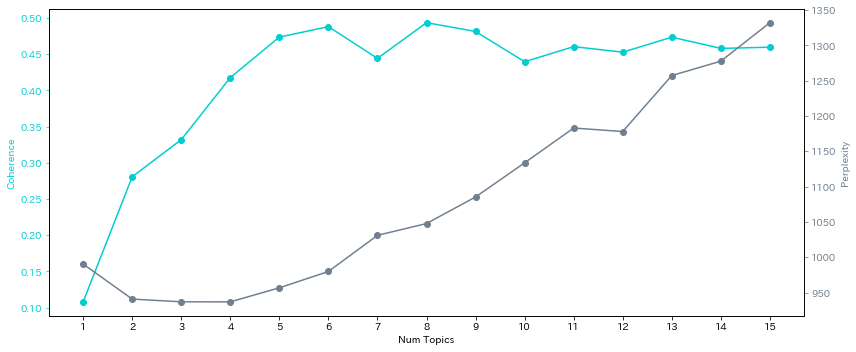

In [ ]:
# トピック数を1-15で実行
n_topics = range(1, 16)
modeling(bow, corpus, dictionary, df, n_topics=n_topics, plotdata=0, iter=3, ee=300, ue=300)

In [ ]:
# トピック6で実行しデータ作成
for n_topics in tqdm([6]):
    model = modeling(bow, corpus, dictionary, df, n_topics=n_topics, applytopic=True)
    print('-'*50)

  0%|          | 0/1 [00:00<?, ?it/s]

n=6: [(2, 162653), (0, 154099), (1, 126519), (3, 91135), (4, 76150), (5, 27617)]


100%|██████████| 1/1 [13:21<00:00, 801.04s/it]

time: 801.04
--------------------------------------------------
